<a id='frontmatter'></a>

# Welcome to `emdfile`!


<hr style="border:2px solid gray">


Below you'll find a sample data analysis process, serving as an introduction to the `emdfile` Python package.

What manner process, you may ask?  This how I have often approached analyzing new data, in three or four passes:
- 1st pass: I'm just trying to figure out what's going on, and the code I write will be ad hoc and sometimes messy, with little attention paid to things like reuseability (e.g. with data from other experiments from the same or different days) or scalability (e.g. to many datasets to achieve better statistics or identify different qualitative behaviors).
- 2nd pass: Having a little more sense of what I'm trying to do, I'll try to tidy up my code into something neater and that may generalize to other datasets.  This is often the point where I might define one or more Python classes.
- 3rd pass: The dreaded I/O! That is, Inputs/Outputs - here, I mean writing some code that will allow saving the results of the analysis, and then loading those results again later.  This is where `emdfile` comes in!
- 4th pass: With the ability to save and re-load data in-hand, I may run the code on many datasets, saving all the results.  Now, if the situation requires, I can load any or all of those results - easily, if my read code is good.


Once upon a time, Step 3 was my arch nemesis: before the `emdfile` package existed, I would typically write some custom read/write code for each analysis, and then modify it every time the analysis code changed. It often felt tedious, and existing packaged solutions either weren't much better or didn't suit my needs.  The goal with this package was to make this step simple and easy.


<hr style="border:2px solid gray">


## Contents 

- [DataGenerator](#datagenerator): Generate data
- [1st pass](#1stpass): initial, messy attempt at data analysis
- [2nd pass](#class): bundling the analysis workflow into a Python class
- [3rd pass](#io): IO with `emdfile`
- [4th pass](#manydatasets): analyze, write, and read many datasets



## See also

- [emdfile_package_walkthrough.ipynb](./emdfile_package_walkthrough.ipynb) for a detailed walkthrough of `emdfile`'s functionality
- [test_custom_class.py](./test_custom_class.py) and [sample_custom_class_module/](./sample_custom_class_module) for an example of a Python module or package built on top of `emdfile`, using it to handle read and write functionality through class inheritance
- [the EMD file specification](https://emdatasets.com/format/)


## Authorship

Benjamin H. Savitzky

April, 2023

<hr style="border:2px solid gray">

 <a id='generatedata'></a>

# Generate Data

In [9]:
# Generate data


# This cell defines a class that makes datasets
# our data will be 3D arrays comprised of 8 frames of 256x256 images, each
# containing a gaussian blob which moves at a constant velocity between frames


shape = (256,256,8)

import numpy as np
from scipy.stats import poisson


class DataGenerator:
    """ This class generates data by
            (1) initializing some starting position `xy0` and velocity `v0`
            (2) finding the position at each of 8 time points
            (3) at each of these 8 time points, place a 2D Gaussian into a 256x256 grid
            (4) generate a 256x256 image at each time point by drawing from a Poisson
                distribution, using an expected value given at each pixel by the Gaussian
    """
    
    params = {'A':5, 'sigx':12, 'sigy':9}  # 2D gaussian parameters
    mu_scale = 1                           # scaling for Poisson draws
    
    def __init__(self, xy0, v0):
        """ 2-tuples xy0 and v0
        """
        
        # set the initial position and velocity
        self.xy0 = np.array(xy0)
        self.v0 = np.array(v0)

        # find the center at each time point
        self.xy = self.xy0[:,np.newaxis] + \
            np.tile(np.arange(8),(2,1))*self.v0[:,np.newaxis]
        
        # make the data
        self.generate_data()


    def generate_data(self):
        """ make a 2D gaussian on a grid, then draw from a Poisson distribution using
            an expected value given at each pixel by the Gaussian
        """
        
        # make a meshgrid
        yy,xx = np.meshgrid(np.arange(shape[1]),np.arange(shape[0]))
        self.xx,self.yy = xx-shape[0]/2., yy - shape[1]/2.
        
        # extend in the third dimension and center
        self.xx = np.dstack([ self.xx[:,:,np.newaxis] - x for x in self.xy[0,:] ])
        self.yy = np.dstack([ self.yy[:,:,np.newaxis] - y for y in self.xy[1,:] ])
        
        # get the data       
        self.data = poisson.rvs(
            self.gaussian((self.xx,self.yy), **(DataGenerator.params)) * DataGenerator.mu_scale
        )
    
    @staticmethod
    def gaussian(p,A,sigx,sigy):
        return A * np.exp(-(0.5*(p[0]/sigx)**2)) * np.exp(-(0.5*(p[1]/sigy)**2))


    
# generate some data
xy0 = (-17,-9)
v0 = (6,8)
data_generator = DataGenerator(xy0, v0)

 <a id='1stpass'></a>

# Analysis: 1st pass

In [139]:
# Visualization utilities

import matplotlib.pyplot as plt


def show_im(im,xy=None):
    """ Show one image, `im`.  If `xy` is passed it specifies one or more points,
        which are overlaid in red
    """
    fig,ax = plt.subplots()
    ax.matshow(im,cmap='gray',vmin=0,vmax=0.5*np.max(im))
    if xy is not None:
        ax.scatter(xy[1],xy[0],color='r',s=16)
    plt.show()
    
def show_ims(ims,xys=None):
    """ Show all 8 images, `ims`.  If `xys` is passed it specifies a point for each image,
        which are overlaid in red
    """
    fig,axs = plt.subplots(2,4,figsize=(12,6))
    for idx in range(8):
        im = ims[:,:,idx]
        ax = axs[idx//4,idx%4]
        ax.matshow(im,cmap='gray',vmin=0,vmax=0.5*np.max(im))
        if xys is not None:
            ax.scatter(xys[1,idx],xys[0,idx],color='r',s=16)
    plt.show()

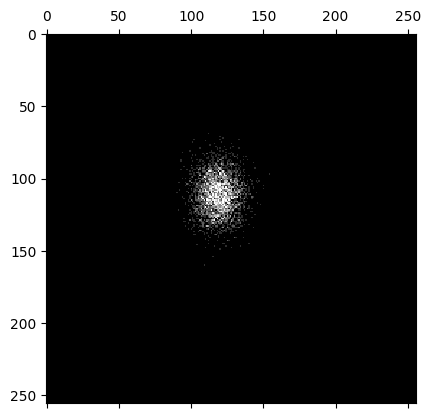

In [140]:
# Show one image from the 8 image dataset

show_im(data_generator.data[:,:,0])

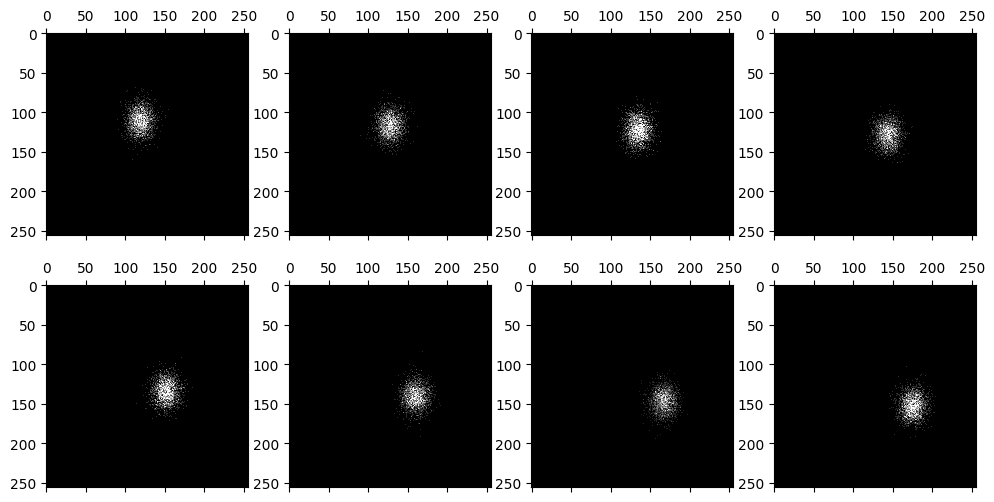

In [141]:
# Show all 8 images

show_ims(data_generator.data)

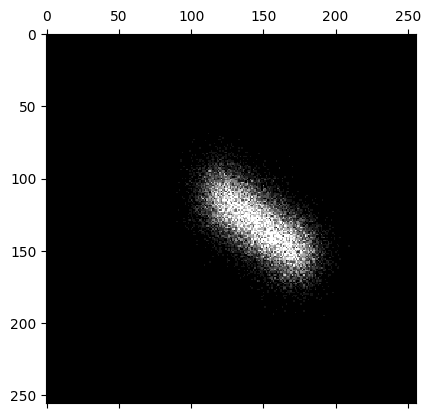

In [129]:
# Find and show the mean of all images

show_im(np.mean(data_generator.data,axis=2))

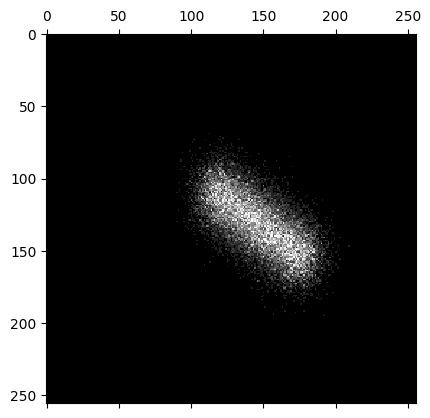

In [130]:
# Find and show the maximum of all images

show_im(np.max(data_generator.data,axis=2))

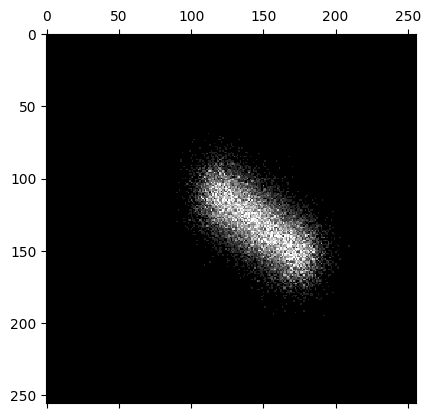

In [142]:
# Find and show the standard deviation of all images

show_im(np.std(data_generator.data,axis=2))

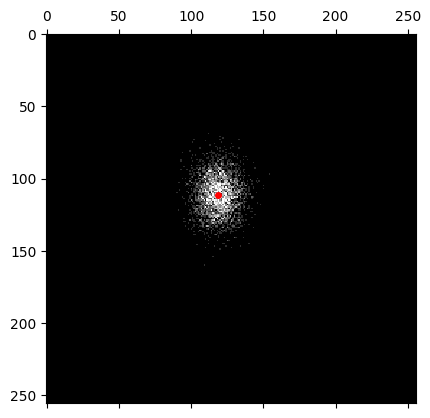

In [143]:
# Find and show the center of mass of all the images

def get_com(im):
    tot = np.sum(im)
    yy,xx = np.meshgrid(np.arange(shape[1]),np.arange(shape[0]))
    return (np.sum(xx*im)/tot, np.sum(yy*im)/tot)

# compute one c.o.m.
com = get_com(data_generator.data[:,:,0])

# show
show_im(data_generator.data[:,:,0],com)

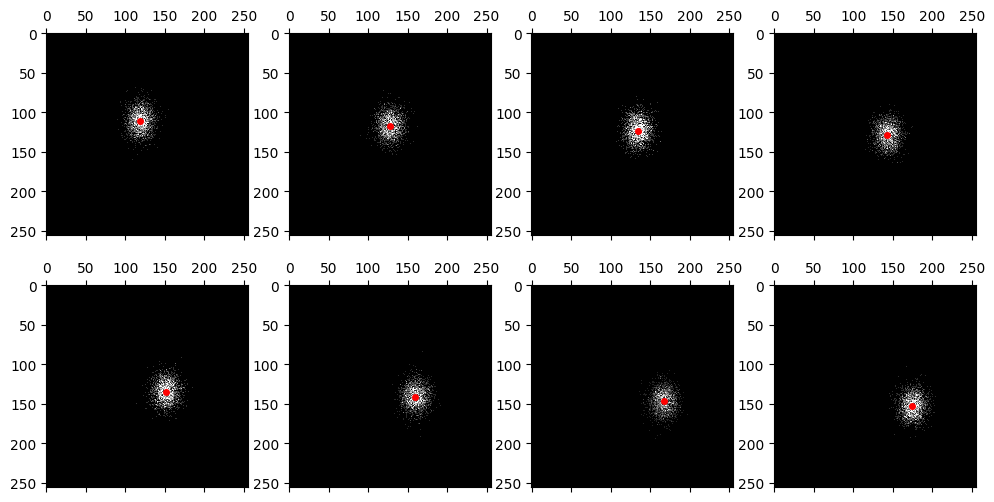

In [144]:
# get all coms and show

coms = np.array([get_com(data_generator.data[:,:,i]) for i in range(shape[2])]).T

show_ims(data_generator.data,coms)

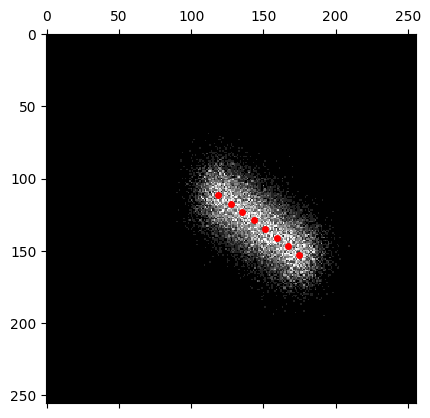

In [145]:
# Show coms over the max image

show_im(
    np.max(data_generator.data,axis=2),
    coms,
)

 <a id='class'></a>


# Analysis: 2nd pass

In this section, the analysis above is wrapped into a class which ingests a single dataset, and has methods to perform each of the steps above.

In [147]:
# Define the analysis class


class VeryScientificAnalysis:
    """
    Analysis for A Very Important Investigation into the Apparent Motion of Fuzzy Looking Blobs
    """
    
    def __init__(self, data):
        """ `data` should be a (256,256,8) shaped array
        """
        self.data = data

        
    # analysis methods
        
    def get_max(self):
        self.max = np.max(self.data,axis=2)
    def get_mean(self):
        self.mean = np.mean(self.data,axis=2)
    def get_std(self):
        self.std = np.std(self.data,axis=2)
    
    @staticmethod
    def get_com(im):
        tot = np.sum(im)
        yy,xx = np.meshgrid(np.arange(shape[1]),np.arange(shape[0]))  # for many datasets, this won't be terribly efficient :p
        return (np.sum(xx*im)/tot, np.sum(yy*im)/tot)
    
    def get_coms(self):
        self.coms = np.array([get_com(self.data[:,:,i]) for i in range(shape[2])]).T


In [149]:
# Perform analysis


# instantiate a class instance
my_analysis = VeryScientificAnalysis( data=data_generator.data )

# analyze
my_analysis.get_max()
my_analysis.get_mean()
my_analysis.get_std()
my_analysis.get_coms()

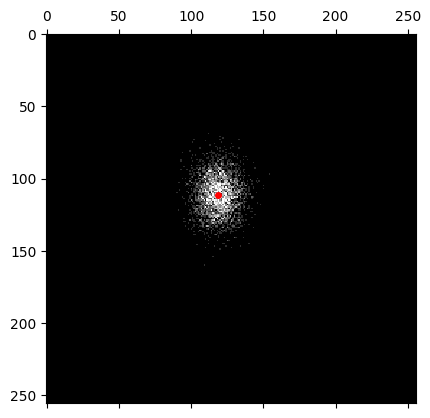

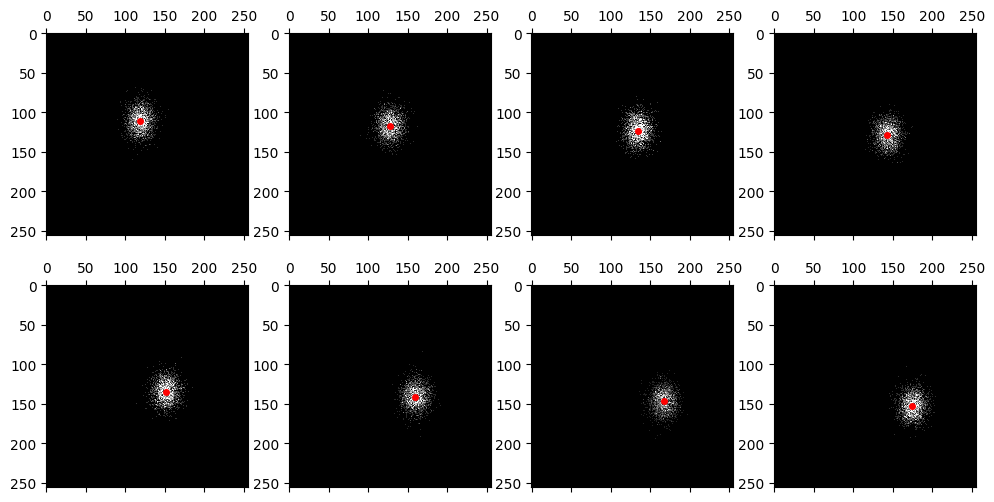

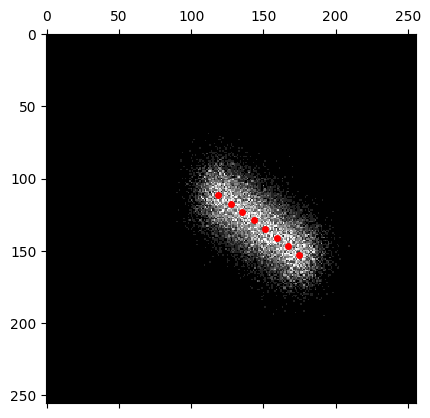

In [156]:
# The visualization are they're the same, with very slightly modified syntax

show_im(
    my_analysis.data[:,:,0],
    coms[:,0]
)
show_ims(
    my_analysis.data,
    coms
)
show_im(
    my_analysis.max,
    coms
)

<a id='io'></a>

# Analysis: 3rd pass - enter `emdfile`

Here we extend the previous class with a new `save` method, which uses `emdfile`.  Reading the data we saved can then accomplished with `emdfile.read`.

The save method in this pass is simple, and supports saving a single analysis to a single file.  In the 4th and final pass, we'll make one more small modification to allow saving as many analyses we like to a single file.

In [161]:
# filepath utilities


# modify this path to point somewhere on your filesystem

filepath = "/Users/Ben/Desktop/test.h5"

In [174]:
# Extend analysis class to support i/o


import emdfile as emd     # the alias `emd` is convenient


class ReadAndWritable_VeryScientificAnalysis:
    """
    Analysis and io for A Very Important Experiment
    """
    
    def __init__(self, data):
        """
        """
        self.data = data

        
    # analysis methods
        
    def get_max(self):
        self.max = np.max(self.data,axis=2)
    def get_mean(self):
        self.mean = np.mean(self.data,axis=2)
    def get_std(self):
        self.std = np.std(self.data,axis=2)
    
    @staticmethod
    def get_com(im):
        tot = np.sum(im)
        yy,xx = np.meshgrid(np.arange(shape[1]),np.arange(shape[0]))
        return (np.sum(xx*im)/tot, np.sum(yy*im)/tot)
    
    def get_coms(self):
        self.coms = np.array([self.get_com(self.data[:,:,i]) for i in range(shape[2])]).T


    
    
    # save

    
    def save(self,filepath):
        """ Save the data.
        """
        
        # wrap the data in emd classes,
        # giving each a descriptive name
        
        ar_max = emd.Array( data=self.max, name='max')
        ar_mean = emd.Array( data=self.mean, name='mean')
        ar_std = emd.Array( data=self.std, name='std' )
        ar_coms = emd.Array( data=self.coms, name='coms' )
        

        
        # write the file

        emd.save(filepath, [
            ar_max,
            ar_mean,
            ar_std,
            ar_coms
            ],
            mode = 'o'   # ** see note below
        )



# ** The line `mode = 'o'` tells `emdfile` to use "overwrite" mode - that is, if a file already exists at this
# location, delete it and write a new file.  If overwrite mode is not specified and there's already a file at
# the given path, `emdfile` will throw an error.  In general, use overwrite mode at your own risk!!

In [175]:
# Analyze the data


# ((instantiate))
my_analysis = ReadAndWritable_VeryScientificAnalysis(
    data=data_generator.data
)

# ((analyze))
my_analysis.get_max()
my_analysis.get_mean()
my_analysis.get_std()
my_analysis.get_coms()


# and save it
my_analysis.save(filepath)

In [176]:
# We can look at the contents of the file without loading anything

emd.print_h5_tree(filepath)

/
|--root
	|--coms
	|--max
	|--mean
	|--std




In [177]:
# And we can load the data

loaded_data = emd.read(filepath)

In [178]:
# In the EMD 1.0 format, each HDF5 file can contain any number of directory-like trees
# (in this case, our file only stores one). `loaded_data` is a `Root` type object because
# we've loaded an entire EMD tree, which we can now access starting from it's root

loaded_data

Root( A Node called 'root', containing the following top-level objects in its tree:

          coms 		 (Array)
          max 		 (Array)
          mean 		 (Array)
          std 		 (Array)
)

In [179]:
# Inspect the contents of the EMD tree

loaded_data.tree()

/
|--coms
|--max
|--mean
|--std


In [180]:
# Access the data

ar_max = loaded_data.tree('max')
ar_mean = loaded_data.tree('mean')
ar_std = loaded_data.tree('std')
ar_coms = loaded_data.tree('coms')

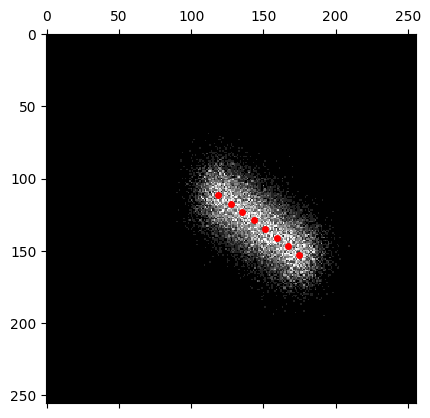

In [181]:
# Visualize

show_im(
    ar_max.data,
    ar_coms.data
)

In [182]:
# Notice that the data itself are no longer numpy ndarrays - they are emd Arrays.

ar_mean

Array( A 2-dimensional array of shape (256, 256) called 'mean',
       with dimensions:

       dim0 = [0,1,...] pixels
       dim1 = [0,1,...] pixels
)

In [183]:
# with the data itself accessible in the .data attribute

ar_mean.data

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

<a id='manydatasets'></a>


# Analysis: 4th pass 

Here we 
- modify our analysis class slightly, to save many analyses to a single file
- generate 100 datasets, analyze them, and save them all
- load from all the datasets and make a plot

In [195]:
# Delete the file from the previous section

from os.path import exists
from os import remove
if exists(filepath):
    remove(filepath)

In [196]:
# Extend analysis class to write many analyses to a single file

# Only a few additional lines of code are needed



class EmdfileAnalysis:
    """
    Analysis and io for A Very Important Experiment
    """
    
    def __init__(self, name, data):
        """
        """
        self.name = name        # add a name as an identifier for each analysis
        self.data = data

        
    # analysis methods
        
    def get_max(self):
        self.max = np.max(self.data,axis=2)
    def get_mean(self):
        self.mean = np.mean(self.data,axis=2)
    def get_std(self):
        self.std = np.std(self.data,axis=2)
    
    @staticmethod
    def get_com(im):
        tot = np.sum(im)
        yy,xx = np.meshgrid(np.arange(shape[1]),np.arange(shape[0]))
        return (np.sum(xx*im)/tot, np.sum(yy*im)/tot)
    
    def get_coms(self):
        self.coms = np.array([self.get_com(self.data[:,:,i]) for i in range(shape[2])]).T


    
    
    # save

    
    def save(self,filepath):
        """ Save the data, writing a new file if the specified filepath doesn't exist,
            or if it does, appending the data to the existing file
        """
        
        # wrap the data in emd classes,
        # giving each a descriptive name
        
        ar_max = emd.Array( data=self.max, name='max')
        ar_mean = emd.Array( data=self.mean, name='mean')
        ar_std = emd.Array( data=self.std, name='std' )
        ar_coms = emd.Array( data=self.coms, name='coms' )
        

        # make an EMD tree
        
        root = emd.Root( name=self.name )
        root.tree( ar_max )
        root.tree( ar_mean )
        root.tree( ar_std )
        root.tree( ar_coms )
                 
        
        # if a file doesn't exist at this location, write a new file.
        # if a file already exists, append new data to it

        if not exists(filepath):
            emd.save(filepath, root)        
        else:
            emd.save(filepath, root, mode = 'a')


In [197]:
# Generate 100 datasets

from scipy.stats import uniform,cosine

centers = uniform.rvs(-10,20,size=(2,100))  # uniform distribution from -10 to 10
vmag = uniform.rvs(0,10,size=100)           # uniform distribution from 0 to 10
vang = cosine.rvs(0,np.pi/4,size=100)       # cosine distribution from -pi/2 to pi/2
velocities = np.vstack(
    [vmag*np.sin(vang),
     vmag*np.cos(vang)]
)


# build the datasets
datasets = []
for idx in range(100):
    
    datasets.append( DataGenerator(centers[:,idx], velocities[:,idx]) )

In [198]:
# Analyze

for idx in range(100):
    
    # instantiate
    analysis = EmdfileAnalysis(
        name = f'experiment_{idx}',
        data = datasets[idx].data
    )

    # analyze
    analysis.get_max()
    analysis.get_mean()
    analysis.get_std()
    analysis.get_coms()
    
    # and save
    analysis.save(filepath)

In [199]:
# The tree for this HDF5 file is large...

emd.print_h5_tree(filepath)

/
|--experiment_0
|	|--coms
|	|--max
|	|--mean
|	|--std
|--experiment_1
|	|--coms
|	|--max
|	|--mean
|	|--std
|--experiment_10
|	|--coms
|	|--max
|	|--mean
|	|--std
|--experiment_11
|	|--coms
|	|--max
|	|--mean
|	|--std
|--experiment_12
|	|--coms
|	|--max
|	|--mean
|	|--std
|--experiment_13
|	|--coms
|	|--max
|	|--mean
|	|--std
|--experiment_14
|	|--coms
|	|--max
|	|--mean
|	|--std
|--experiment_15
|	|--coms
|	|--max
|	|--mean
|	|--std
|--experiment_16
|	|--coms
|	|--max
|	|--mean
|	|--std
|--experiment_17
|	|--coms
|	|--max
|	|--mean
|	|--std
|--experiment_18
|	|--coms
|	|--max
|	|--mean
|	|--std
|--experiment_19
|	|--coms
|	|--max
|	|--mean
|	|--std
|--experiment_2
|	|--coms
|	|--max
|	|--mean
|	|--std
|--experiment_20
|	|--coms
|	|--max
|	|--mean
|	|--std
|--experiment_21
|	|--coms
|	|--max
|	|--mean
|	|--std
|--experiment_22
|	|--coms
|	|--max
|	|--mean
|	|--std
|--experiment_23
|	|--coms
|	|--max
|	|--mean
|	|--std
|--experiment_24
|	|--coms
|	|--max
|	|--mean
|	|--std
|--experime

In [204]:
# Later we can come back and load the data.

# Because this EMD file contains many EMD trees, passing its path to the read function without specifying
# which tree we want will return a list of 


loaded_data = emd.read(filepath)

print()

loaded_data

Multiple root groups detected - returning root names. Please specify the `emdpath` argument. Returning the list of rootgroups.



['experiment_0',
 'experiment_1',
 'experiment_10',
 'experiment_11',
 'experiment_12',
 'experiment_13',
 'experiment_14',
 'experiment_15',
 'experiment_16',
 'experiment_17',
 'experiment_18',
 'experiment_19',
 'experiment_2',
 'experiment_20',
 'experiment_21',
 'experiment_22',
 'experiment_23',
 'experiment_24',
 'experiment_25',
 'experiment_26',
 'experiment_27',
 'experiment_28',
 'experiment_29',
 'experiment_3',
 'experiment_30',
 'experiment_31',
 'experiment_32',
 'experiment_33',
 'experiment_34',
 'experiment_35',
 'experiment_36',
 'experiment_37',
 'experiment_38',
 'experiment_39',
 'experiment_4',
 'experiment_40',
 'experiment_41',
 'experiment_42',
 'experiment_43',
 'experiment_44',
 'experiment_45',
 'experiment_46',
 'experiment_47',
 'experiment_48',
 'experiment_49',
 'experiment_5',
 'experiment_50',
 'experiment_51',
 'experiment_52',
 'experiment_53',
 'experiment_54',
 'experiment_55',
 'experiment_56',
 'experiment_57',
 'experiment_58',
 'experiment_59'

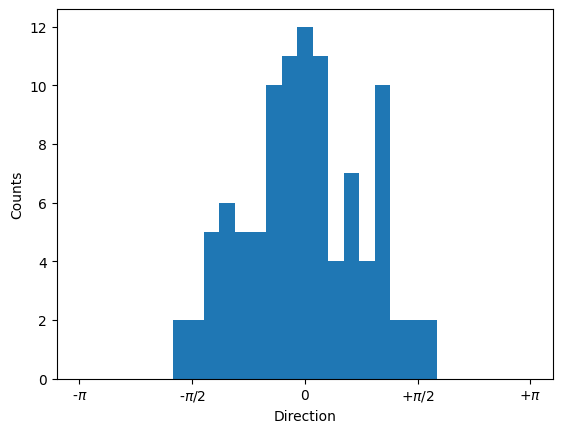

In [221]:
# Let's imagine we realized later that what we really wanted to know from this data
# was the velocity of each blob.  Maybe we want to know if they moved preferentially in
# a particular direction.

# We didn't find the velocities in our previous analysis, but we *did* find the centers
# of the blobs in each frame.  Since everything is saved to our file, we can now load
# those center positions, compute the velocities, and then visualize them without
# needing to repeat any calculations.


orientations = np.empty(100)

for idx,rootname in enumerate(loaded_data):         # loop through all the experiments
    
    root = emd.read(filepath, emdpath=rootname)     # load the EMD tree from an experiment
    coms = root.tree('coms')                        # get the centers of mass
    v_mean = coms[:,-1] - coms[:,0]                 # find the velocity
    orientations[idx] = np.angle(-1j*v_mean[0]+v_mean[1])     # find the direction

    
# plot a histogram
fig,ax = plt.subplots()
ax.hist(orientations, bins=np.linspace(-np.pi,np.pi,30))
ax.set_xticks(np.linspace(-np.pi,np.pi,5))
ax.set_xticklabels([r'-$\pi$',r'-$\pi/2$',r'0',r'+$\pi/2$',r'$+\pi$'])
ax.set_xlabel('Direction')
ax.set_ylabel('Counts')
plt.show()